In [83]:
!pip install keras
!pip install h5py

In [84]:
from keras.datasets import cifar10
from keras.utils import to_categorical as np_utils
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [85]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


In [86]:
print('Training images: {}'.format(X_train.shape))
print('Testing images: {}'.format(X_test.shape))

Training images: (50000, 32, 32, 3)
Testing images: (10000, 32, 32, 3)


In [87]:
print(X_train[0].shape)#should be and is 32x32x3

(32, 32, 3)


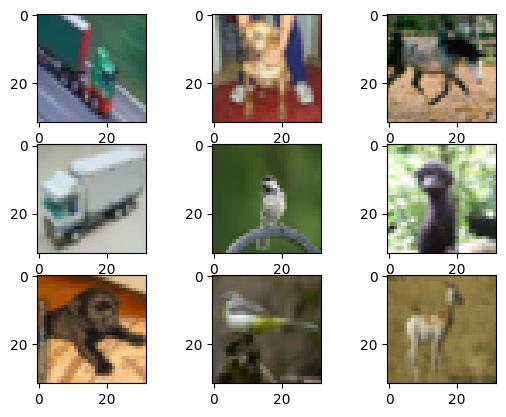

In [88]:
#create a grid of 3x3 images(9 images of 3x3 subplots)
for i in range(0,9):
    plt.subplot(330+1+i)#denotes 3x3 and postion
    img=X_train[i+50]#no need to transpose else transpose([1,2,0])
    plt.imshow(img)

plt.show()

***On the given set, images are blurry(32x32 pixels only), Humans were only 94% accurate in classifying***

# Preprocessing the dataset
 we need to preprocess the dataset so the images and labels are in a form that Keras can ingest
- normalize the images.
- convert our class labels to one-hot vectors. This is a standard output format for neural networks.

### Building a convolutional neural network for object recognition on CIFAR-10


In [89]:
print(X_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [90]:
seed=6
np.random.seed(seed)

#again load the dataset as we set the random seed and not apllying any shuffling effects or random effects
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize the inputs from 0-255(RGB) to 0.0-1.0
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train=X_train/255.0
X_test=X_test/255.0

In [91]:
print(X_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


In [92]:
print(y_train.shape)
print(y_train[0])
print(y_train.min())
print(y_train.max())
#0 to 9

(50000, 1)
[6]
0
9


The class labels are a single integer value (0-9). What we really want is a one-hot vector of length ten(cuz it is easier for CNN to output and it avoids biases to higher numbers; CNN is numerical,ex , a class value of 6 would skew the weights a lot differently than class label 1 ). For example, the class label of 6 should be denoted [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]. We can accomplish this using the np_utils.to_categorical() function

In [93]:
#hot encode outputs
Y_train= to_categorical(y_train)
Y_test= to_categorical(y_test)
num_classes=Y_test.shape[1]

print(Y_train.shape)
print(Y_train[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Building the All-CNN
Using the paper as a reference, we can implement the All-CNN network in Keras. Keras models are built by simply adding layers, one after another.

We will wrap this model in a function, which will allow us to quickly and neatly generate the model later on in the project.

In [94]:
from keras.models import Sequential
from keras.layers import Dropout,Activation,Conv2D,GlobalAveragePooling2D
#conv2d is the main convulational layer
from keras.optimizers import SGD#stochastic gradient descent

In [95]:
def allcnn(weights=None):
    #taking random weights ny default else usr passed pretrained weights

    model=Sequential()#we will be adding one layer after another

    #not the input layer but need to tell the conv. layer to accept input
    model.add(Conv2D(96,(3,3),padding='same',input_shape=(32,32,3)))#32x32x3 channels
    model.add(Activation('relu'))#required for each conv. layer
    model.add(Conv2D(96,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3,3),padding='same',strides=(2,2)))
    model.add(Dropout(0.5))#drop neurons randomly;helps the network generalize(prevent overfitting on training data) better so instead of having individual neurons
    #that are controlling specific classes/features, the features are spread out over the entire network

    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3,3),padding='same',strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1,1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10,(1,1),padding='valid'))

    # add GlobalAveragePooling2D layer with Softmax activation
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))

    #load the weights,if passed
    if weights:
        model.load_weights(weights)

    #return model
    return model

# Defining Parameters and Training the Model
- define hyper parameters, such as learning rate and momentum,
- define an optimizer,
- compile the model, and
- fit the model to the training data.

## The original paper mentions that it took approximately 10 hours to train the All-CNN network for 350 epochs using a modern GPU, which is considerably faster (several orders of magnitude) than it would take to train on CPU.
***we'll save some time by loading pre-trained weights for the All-CNN network. Using these weights, we can evaluate the performance of the All-CNN network on the testing dataset.***

In [96]:
#define the hyper parameters(generic or do Grid Search)
learning_rate=0.01
weight_decay=1e-6
momentum=0.9

#define training parameters
epochs=350 #from research paper
batch_size=32#run 32 images times then update the parameters instead of updating them after every image

model=allcnn()

#define optimizer and compile model
sgd=SGD(lr=learning_rate,weight_decay=weight_decay,momentum=momentum,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

print(model.summary())#1.3m parameters and all are trainable

# #fit the model(update the parameters and loss)
# model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=epochs,batch_size=batch_size,verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 32, 32, 96)        2688      
                                                                 
 activation_63 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 32, 32, 96)        83040     
                                                                 
 activation_64 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 conv2d_83 (Conv2D)          (None, 16, 16, 96)        83040     
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 96)        0         
                                                                 
 conv2d_84 (Conv2D)          (None, 16, 16, 192)      

In [97]:
# define hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9
#no need for training parameters

# define weights and build model
weights='/content/all_cnn_weights_0.9088_0.4994.hdf5'#KERAS format hdf5
#pretrained weights  that have already gone through the above press
model=allcnn(weights)

# define optimizer and compile model
sgd=SGD(lr=learning_rate,weight_decay=weight_decay,momentum=momentum,nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#measure of model's perfrmane is accuracy

# print model summary
print (model.summary())

# test the model with pretrained weights
scores=model.evaluate(X_test,Y_test,verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 96)        2688      
                                                                 
 activation_70 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 conv2d_91 (Conv2D)          (None, 32, 32, 96)        83040     
                                                                 
 activation_71 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 conv2d_92 (Conv2D)          (None, 16, 16, 96)        83040     
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 96)        0         
                                                                 
 conv2d_93 (Conv2D)          (None, 16, 16, 192)     

Not state of the art accuracy((95.59% achieved accd. to paper, highest being 96.53% by Fractional Max-Pooling), But still good considering humans were only 94% accurate. This might be because  of the pre trained weights depended on the way PAN001 trained the model.

In the paper they go into a fairly extensive data augmentation process. Data augmentation means adding slight variations t the image like rotations, blurriness, noise to help network generalize better to the testing dataset.

In [98]:
classes=range(0,10)#10 not included

names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# zip the names and classes to make a dictionary of class_labels
class_labels=dict(zip(classes,names))
print(class_labels)
# generate batch of 9 images to predict
batch=X_test[100:109]
labels=np.argmax(Y_test[100:109],axis=-1)

#make predictions
predictions=model.predict(batch,verbose=1)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
1/1 [==============================] - 0s 94ms/step


In [99]:
print(predictions)
print(predictions.shape)

[[4.5646539e-18 1.0580782e-20 1.8922991e-10 2.1411080e-11 9.9999928e-01
  2.8037175e-07 3.1478308e-13 4.2380964e-07 1.3699244e-19 1.2096743e-18]
 [2.1191146e-16 2.0387092e-17 1.5672826e-09 5.3582534e-07 1.6256357e-10
  9.9999940e-01 1.6712842e-09 2.0782148e-08 3.6549311e-15 3.5128868e-16]
 [1.2720419e-30 5.0273262e-28 5.1539829e-24 3.6052098e-21 1.0875017e-27
  8.1522779e-22 1.0000000e+00 1.1050823e-27 6.1925089e-32 1.2274146e-23]
 [1.5143829e-16 4.7668326e-18 2.2583910e-09 1.0000000e+00 4.3482291e-11
  1.6884145e-12 4.5318334e-13 2.6686954e-16 7.2658599e-19 6.2050179e-17]
 [8.2497943e-36 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.3560188e-36 8.6864647e-30 8.2191950e-22]
 [5.9703147e-24 1.0000000e+00 7.5488142e-27 8.0231137e-27 1.9714703e-30
  2.7339758e-29 7.2190141e-31 5.5682706e-27 1.6187424e-26 1.1906559e-13]
 [6.4565029e-18 2.9643442e-20 1.0046476e-11 9.9999988e-01 6.0156014e-13
  9.1111851e-08 7.8876454e-12 1.1608435e-15 7.8591060e-21 

for an image, we get probability for each class which is the ouput from the softmax layer

In [100]:
#these are individual class probabilities, should sum to 1.0
for image in predictions:
    print(np.sum(image))

#shows that there is hundred percent probability that images to belong to one of the classes

1.0
0.99999994
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [101]:
# use np.argmax() to convert class probabilities to class labels
class_result=np.argmax(predictions,axis=-1)
print(class_result)

[4 5 6 3 1 1 3 6 8]


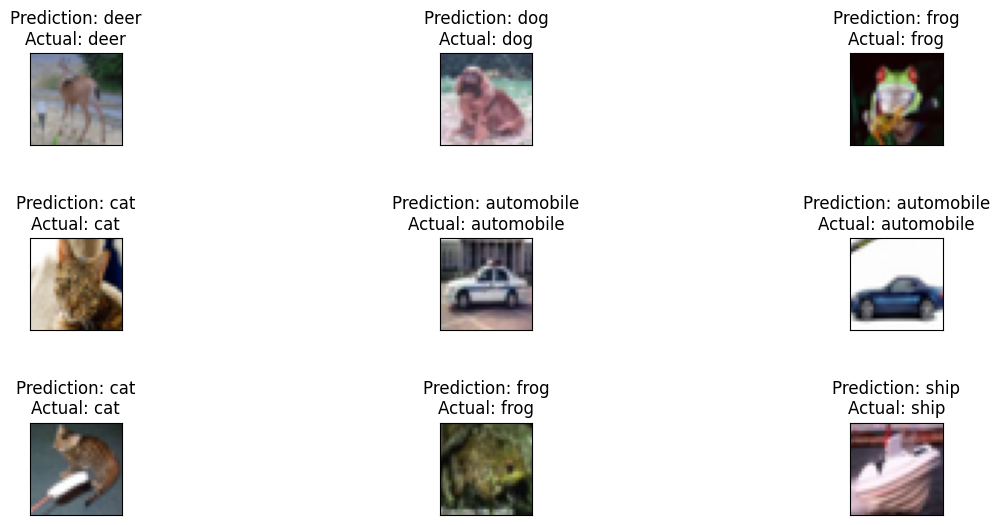

In [102]:
#create a grid of 3x3 images
fig,axs=plt.subplots(3,3,figsize=(15,6))
fig.subplots_adjust(hspace=1)
axs=axs.flatten()

for i,img in enumerate (batch):
        # determine label for each prediction, set title
        for key,value in class_labels.items():
            if class_result[i]==key:
                title = 'Prediction: {}\nActual: {}'.format(class_labels[key], class_labels[labels[i]])
                axs[i].set_title(title)
                axs[i].axes.get_xaxis().set_visible(False)
                axs[i].axes.get_yaxis().set_visible(False)

        # plot the image
        axs[i].imshow(img)

# show the plot
plt.show()

To use object recognition for your dataset, you will take the pretrained weights and then do fine tuning,ie, additional training on your dataset to convert some of these cnn's into a network that can produce result for your dataset.Fine tuning will require a GPU.

However, we can use a lot of the info that has already been learned by this network. So in the pretrained weights, we have like feature extractors, in some of those first layers we have group of neurons that does edge detection, shape detection,etc AND those things transfer really well.

So if you are using this on your own dataset, all you have to do is fine tuning; you don't have to that initial traing from random weights.SAVES TIME!!!